In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import time
# import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_06 as sg

# Generate the toy dataset

Generate two clusters of 2D vectors far enough from each other to be easily separable and both Gaussian distributed.

In [2]:
# if the number of data points in one set is odd, the -1 cluster is favored; i.e. there is one extra point in the -1 cluster
train_num = 210
val_num = 100
error_train_num = 30
error_val_num = 15

cpos_center = (3,10)
cpos_scale = (1, 4)
cneg_center = (3, 10)
cneg_scale = (1, 4)

# generate the training data
train_des = np.zeros((train_num, 2))
rng = np.random.default_rng(seed=0)
train_des[:train_num//2,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(train_num//2,)) # first dimension of datapoints for 1 cluster
train_des[:train_num//2,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(train_num//2,)) # second dimension of datapoints for 1 cluster
train_des[train_num//2:,0]=  rng.normal(loc=cneg_center[0], scale=cneg_scale[0], size=(np.ceil(train_num/2).astype(int),)) # first dimension of datapoints for -1 cluster
train_des[train_num//2:,1]=  rng.normal(loc=cneg_center[1], scale=cneg_scale[1], size=(np.ceil(train_num/2).astype(int),)) # second dimension of datapoints for -1 cluster
train_lbls = np.append(np.ones(train_num//2), -1 * np.ones(np.ceil(train_num/2).astype(int)))

# generate the validation data
val_des = np.zeros((val_num, 2))
rng = np.random.default_rng(seed=0)
val_des[:val_num//2,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(val_num//2,)) # first dimension of datapoints for 1 cluster
val_des[:val_num//2,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(val_num//2,)) # second dimension of datapoints for 1 cluster
val_des[val_num//2:,0]=  rng.normal(loc=cneg_center[0], scale=cneg_scale[0], size=(np.ceil(val_num/2).astype(int),)) # first dimension of datapoints for -1 cluster
val_des[val_num//2:,1]=  rng.normal(loc=cneg_center[1], scale=cneg_scale[1], size=(np.ceil(val_num/2).astype(int),)) # second dimension of datapoints for -1 cluster
val_lbls = np.append(np.ones(val_num//2), -1 * np.ones(np.ceil(val_num/2).astype(int)))

# error train
cpos_center = (10,10)
cpos_scale = (5, 4)
train_des[:error_train_num,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(error_train_num,)) # first dimension of datapoints for 1 cluster
train_des[:error_train_num,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(error_train_num,)) # second dimension of datapoints for 1 cluster

# error val
val_des[:error_val_num,0]=  rng.normal(loc=cpos_center[0], scale=cpos_scale[0], size=(error_val_num,)) # first dimension of datapoints for 1 cluster
val_des[:error_val_num,1]=  rng.normal(loc=cpos_center[1], scale=cpos_scale[1], size=(error_val_num,)) # second dimension of datapoints for 1 cluster

In [3]:
val_lbls

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

Text(0.5, 1.0, 'Validation Dataset')

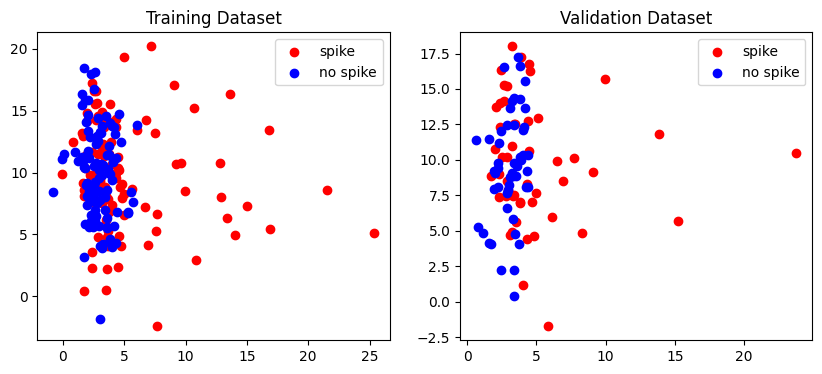

In [4]:
# visualize the datasets
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(train_des[:train_num//2,0], train_des[:train_num//2,1], color='r')
plt.scatter(train_des[train_num//2:,0], train_des[train_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Training Dataset')

plt.subplot(1,2,2)
plt.scatter(val_des[:val_num//2,0], val_des[:val_num//2,1], color='r')
plt.scatter(val_des[val_num//2:,0], val_des[val_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Validation Dataset')

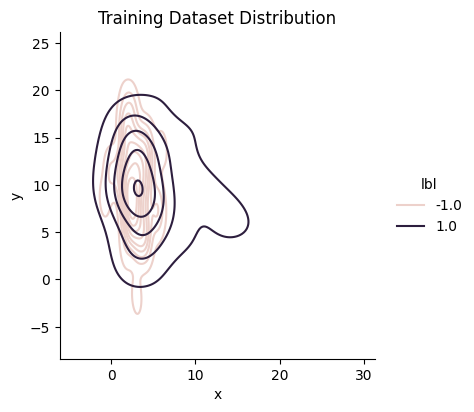

In [5]:
train_dataframe = pd.DataFrame(np.append(train_des, train_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])
val_dataframe = pd.DataFrame(np.append(val_des, val_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])


g = sns.displot(train_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
g.set(title='Training Dataset Distribution')

# g = sns.displot(val_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
# g.set(title='Validation Dataset Distribution')

# Train the logistic regression model

In [6]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

In [7]:
print('Parameters used for fitting: \n', lgrg.get_params())

Parameters used for fitting: 
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [8]:
# train the model  
lgrg = lgrg.fit(train_des, train_lbls)

## Analyze the optimized parameters

In [9]:
# print optimized parameters
print('classes = ', lgrg.classes_)
print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary coefficients =  [[0.43099077 0.01172254]]
decision boundary bias =  [-1.64916146]
number of features seen during fit =  2
number of iterations done during fit =  [12]


In [10]:
# compute confidence scores - positive means +1 while negative means -1
print('a(x) for all x\'s = \n', lgrg.decision_function(val_des))

a(x) for all x's = 
 [ 1.25956633e+00  1.80324556e+00  4.46236731e-01  1.97176861e+00
  2.83200469e+00  4.45370145e+00  1.44483757e+00  2.36729053e+00
 -2.99327315e-01  8.57286398e-01  8.72203322e+00  4.97160471e+00
  1.04702289e+00 -1.34079675e-01  7.09973448e-01 -5.66688702e-01
 -3.99285009e-01 -3.13374220e-01 -3.18567459e-02  1.07026974e-01
 -2.91921326e-01  3.82027587e-01 -4.78580558e-01 -1.16439888e-01
  2.35858011e-01 -2.60360517e-01 -5.90424195e-01 -5.92374200e-01
 -4.33939147e-01 -5.01691286e-02 -6.65260143e-01 -3.58807039e-01
 -3.25292246e-01 -5.70282880e-02 -2.06358256e-01 -5.62412605e-02
 -4.93506854e-01 -2.34123919e-01  6.35388814e-02  4.83893855e-01
 -7.95085003e-01  4.87347726e-01  3.20802767e-01  6.32873493e-02
 -1.13273305e-01 -3.25896547e-01  3.96979507e-01  5.78433981e-01
  4.74634266e-01  2.62116349e-01 -3.58523598e-02  1.91507638e-01
 -3.49611339e-01 -7.25948232e-01  1.36768605e-01 -8.60451186e-01
 -5.32190313e-01  2.37154990e-02 -1.26435240e+00 -1.84895530e-01
 -4.

In [11]:
lgrg.predict_log_proba(val_des)

array([[-1.50937289e+00, -2.49806565e-01],
       [-1.95576342e+00, -1.52517866e-01],
       [-9.40952631e-01, -4.94715899e-01],
       [-2.10210403e+00, -1.30335416e-01],
       [-2.88923029e+00, -5.72255999e-02],
       [-4.46526970e+00, -1.15682483e-02],
       [-1.65654346e+00, -2.11705887e-01],
       [-2.45688839e+00, -8.95978523e-02],
       [-5.54641566e-01, -8.53968881e-01],
       [-1.21097524e+00, -3.53688845e-01],
       [-8.72219616e+00, -1.62942253e-04],
       [-4.97851281e+00, -6.90809926e-03],
       [-1.34785397e+00, -3.00831071e-01],
       [-6.28352832e-01, -7.62432507e-01],
       [-1.10986120e+00, -3.99887751e-01],
       [-4.49418939e-01, -1.01610764e+00],
       [-5.13302248e-01, -9.12587258e-01],
       [-5.48685594e-01, -8.62059813e-01],
       [-6.77345659e-01, -7.09202405e-01],
       [-7.48091831e-01, -6.41064857e-01],
       [-5.57801165e-01, -8.49722491e-01],
       [-9.02294239e-01, -5.20266652e-01],
       [-4.82217697e-01, -9.60798255e-01],
       [-6.

In [13]:
ylimup

21.3414482668152

[Text(0.5, 1.0, 'Logistic Regression Decision Boundary on Train Data')]

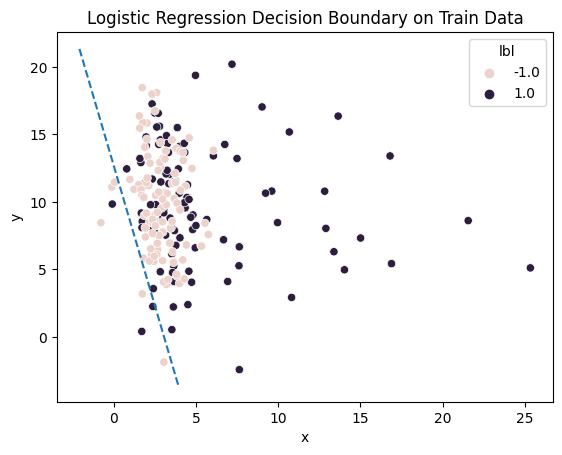

In [14]:
# draw a scatterplot of train data
g = sns.scatterplot(x=train_dataframe.x, y=train_dataframe.y, hue=train_dataframe.lbl)

# draw the optimized decision boundary
slope = -lgrg.coef_[0,0] / lgrg.coef_[0,1]
intercept = -lgrg.intercept_[0] / lgrg.coef_[0,1]
decision_x = np.array(g.get_xlim())
decision_y = intercept + slope * decision_x
[y_limlo, y_limup] = np.array(g.get_ylim())
if decision_y[0] > y_limup:
    decision_y[0] = y_limup
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[0] < y_limlo:
    decision_y[0] = y_limlo
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[1] > y_limup:
    decision_y[1] = y_limup
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
if decision_y[1] < y_limlo:
    decision_y[1] = y_limlo
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
g.plot(decision_x, decision_y, '--')
g.set(title='Logistic Regression Decision Boundary on Train Data')

# Validate the logistic regression model

In [15]:
# validate the model
preds = lgrg.predict(val_des)
val_acc = lgrg.score(val_des, val_lbls)

print('Predicted labels WITH threshold =\n', preds)
print('Validation accuracy =\n', val_acc)

Predicted labels WITH threshold =
 [ 1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.
 -1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]
Validation accuracy =
 0.59


# Train the similarity graph model

In [16]:
# import importlib
# importlib.reload(sg)

In [17]:
B0 = np.array([[0,1], [1,0]])

# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'random', 'cnstr_method_vv': 'random', 'cnstr_method_vt': 'random',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':16, 'check_freq':1, 'print_checks':True, 'Theta0':B0, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B, sg_stats = sg.fit_graph(dess=train_des, lbls=train_lbls, graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

print('Final optimized B=\n', B)

Number of training datapoints: 210
Number of features for each point: 2
mu = 30
   0: eps = 1.95e-03;  train loss (E) = 1063.46
   1: eps = 3.91e-03;  train loss (E) = 793.85
   2: eps = 7.81e-03;  train loss (E) = 689.14
   3: eps = 3.91e-03;  train loss (E) = 676.64
   4: eps = 7.81e-03;  train loss (E) = 676.42
   5: eps = 7.81e-03;  train loss (E) = 676.41
   6: eps = 7.81e-03;  train loss (E) = 676.40
   7: eps = 7.81e-03;  train loss (E) = 676.39
   8: eps = 7.81e-03;  train loss (E) = 676.38
   9: eps = 7.81e-03;  train loss (E) = 676.37
  10: eps = 7.81e-03;  train loss (E) = 676.37
  11: eps = 7.81e-03;  train loss (E) = 676.37
  12: eps = 7.81e-03;  train loss (E) = 676.36
  13: eps = 7.81e-03;  train loss (E) = 676.36
  14: eps = 7.81e-03;  train loss (E) = 676.36
  15: eps = 7.81e-03;  train loss (E) = 676.36
Elapsed time = 4.313892364501953 sec
Final optimized B=
 [[0.07401968 2.35927603]
 [2.32976884 0.06471569]]


## Analyze the optimized parameters

In [18]:
def domain_to_image_1D(pts, B):
    """
    Inputs:
    pts - Nx2 matrix of N points in the domain space - i.e. the eucleadian space
    B - 2x2 optimized linear operator
    
    Output:
    image_pts - Nx2 images of the pts
    """
    return pts @ B.T

def domain_to_image_2D(x, y, B):
    z = x.copy()
    for row_i in range(len(x)):
        temp = np.append(x[row_i].reshape((-1,1)), y[row_i].reshape((-1,1)), axis=1)
        z[row_i] = np.linalg.norm(temp @ B.T, axis=1)
        
    return z

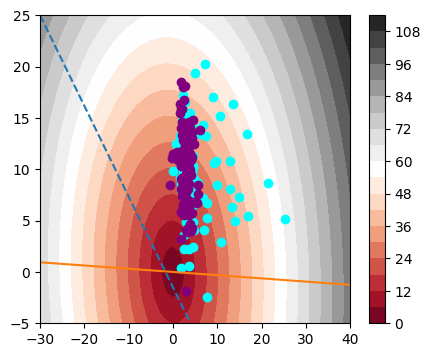

In [19]:
y_limlo = -5
y_limup = 25
x = np.linspace(-30, 40, 50)
y = np.linspace(y_limlo, y_limup, 50)
X, Y = np.meshgrid(x, y)
Z = domain_to_image_2D(X,Y,B)

# draw contours of the image space
fig = plt.figure(figsize=(5,4))
plt.contourf(X, Y, Z, 20, cmap='RdGy')
ax = fig.axes[0]
plt.colorbar()

# draw Logistic Regression's decision boundary
slope = -lgrg.coef_[0,0] / lgrg.coef_[0,1]
intercept = -lgrg.intercept_[0] / lgrg.coef_[0,1]
decision_x = np.array(ax.get_xlim())
decision_y = intercept + slope * decision_x
if decision_y[0] > y_limup:
    decision_y[0] = y_limup
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[0] < y_limlo:
    decision_y[0] = y_limlo
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[1] > y_limup:
    decision_y[1] = y_limup
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
if decision_y[1] < y_limlo:
    decision_y[1] = y_limlo
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
ax.plot(decision_x, decision_y, '--')

# draw the line created by the first row of B
slope = -1 * B[0,0] / B[0,1]
intercept = 0
decision_x = np.array(ax.get_xlim())
decision_y = intercept + slope * decision_x
if decision_y[0] > y_limup:
    decision_y[0] = y_limup
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[0] < y_limlo:
    decision_y[0] = y_limlo
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[1] > y_limup:
    decision_y[1] = y_limup
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
if decision_y[1] < y_limlo:
    decision_y[1] = y_limlo
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
ax.plot(decision_x, decision_y, '-')

ax.scatter(train_des[:train_num//2,0], train_des[:train_num//2,1], color='cyan')
ax.scatter(train_des[train_num//2:,0], train_des[train_num//2:,1], color='purple')

B = 
 [[0.07401968 2.35927603]
 [2.32976884 0.06471569]]


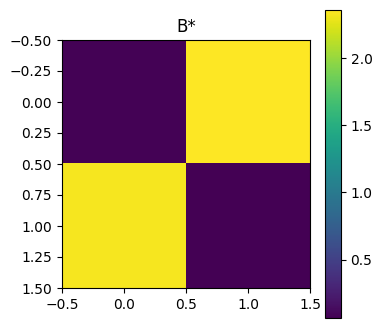

In [20]:
# display the optimized B
print('B = \n', B)
sg.display_matrix(B, 'B*')

# # display the optimized M
# M = B.T @ B
# print('M = \n', M)
# sg.display_matrix(M, 'M*')

# Validate the similarity graph

In [21]:
M = B.T @ B
val_acc, y_est, t = sg.get_acc(M, train_des, train_lbls, val_des, val_lbls, sg_params, seed=0, show_edges=False)
print('Elapsed time = {} ms'.format(t*1000))

Elapsed time = 107.05876350402832 ms


In [22]:
# print results
print('val acc = {:.2f}%'.format(val_acc*100))
print('estimated val labels WITH threshold = ', 2*(y_est>0).astype(np.int32)-1)
print('Estimated validation labels withOUT threshold:\n', y_est)

val acc = 56.00%
estimated val labels WITH threshold =  [ 1  1 -1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1
  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1  1  1 -1  1  1  1
  1 -1  1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1 -1 -1 -1
 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1  1  1
 -1 -1 -1  1]
Estimated validation labels withOUT threshold:
 [ 3.53348460e-02  5.82632014e-03 -3.39563487e-01  1.00000001e+00
  1.00000000e+00  6.14726276e-02  7.08050040e-01  1.00024587e+00
 -2.80060724e-01  5.24699520e-05  7.15235774e-18  1.31879642e-01
 -9.19020677e-01  1.08306378e-01 -9.54184930e-01 -6.88737254e-01
  4.44360845e-01  9.33342309e-01  2.99584252e-01  1.00000000e+00
 -6.97210262e-01 -5.73107629e-01  1.40876206e-01  1.78678194e-01
  6.54190920e-02  3.79998405e-01 -5.37982906e-01 -3.96111159e-01
 -2.72357172e-01 -9.94230151e-01 -4.62386481e-01 -2.66289775e-01
 -5.80639916e-01 -5.21792285e-01  4.94964385e-01  2.51296861e-01
 -7.4

In [23]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_lbls==1]
est_spikes = val_loc[y_est > 0]

if sum(val_lbls==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_lbls==1, y_est < 0))/sum(val_lbls==1)

if sum(val_lbls==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_lbls==-1, y_est > 0))/sum(val_lbls==-1)

nospk_per = np.sum(val_lbls==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [ 0  1  3  4  5  6  7  9 10 11 13 16 17 18 19 22 23 24 25 34 35 37 38 39
 41 42 43 45 46 47 48 50 51 53 55 59 61 63 64 65 66 68 77 78 82 83 85 86
 87 89 90 91 92 94 95 99]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 38.00%
False spikes (/all no-spike bins): 50.00%
